In [1]:
import os
import random
import warnings

import cv2
import gdown
from functools import partial

warnings.simplefilter(action="ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

import numpy as np
import pandas as pd
from matplotlib import cm
from numpy.random import rand
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop

physical_devices = tf.config.list_physical_devices("GPU")
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    tf.config.optimizer.set_jit(True)
    keras.mixed_precision.set_global_policy("mixed_float16")
except:
    pass

seed = 1337
tf.random.set_seed(seed)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3090, compute capability 8.6


In [2]:
train_dir = "F:/WBC/WBC/train"
val_dir = "F:/WBC/WBC/val"
test_dir = "F:/WBC/WBC/test"

datagen_train = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  horizontal_flip=True,
                                  vertical_flip=False)

datagen_val = ImageDataGenerator(rescale=1./255)


datagen_test = ImageDataGenerator(rescale=1./255)


batch_size = 16
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=(384, 384),
                                                    batch_size=batch_size,
                                                    shuffle=True)

generator_val = datagen_test.flow_from_directory(directory=val_dir,
                                                  target_size=(384, 384),
                                                  batch_size=batch_size,
                                                  shuffle=False)

generator_test = datagen_train.flow_from_directory(directory=test_dir,
                                                    target_size=(384, 384),
                                                    batch_size=batch_size,
                                                    shuffle=False)

Found 2043 images belonging to 10 classes.
Found 675 images belonging to 10 classes.
Found 675 images belonging to 10 classes.


In [3]:
# base cnn models
base = keras.applications.VGG19(
    include_top=False,
    weights='imagenet',
    pooling="avg",
    input_tensor=keras.Input((384, 384, 3)),
)

In [4]:
x = Dense(10, activation="softmax", name="output")(base.output)
model = Model(inputs=base.input, outputs=x)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 384, 384, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 384, 384, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 384, 384, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 192, 192, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 192, 192, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 192, 192, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 96, 96, 128)       0     

In [5]:
optimizer = Adam(lr=1e-5)
loss = 'categorical_crossentropy'
metrics = ['categorical_accuracy']
#metrics = [tf.keras.metrics.AUC(), tfa.metrics.CohenKappa(num_classes = 10), tfa.metrics.F1Score(num_classes = 10), tf.keras.metrics.Precision, tf.keras.metrics.Recall]


model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [6]:
epochs = 50
batch_size = 32

steps_per_epoch = generator_train.n / batch_size
steps_test = generator_val.n / batch_size

history = model.fit(generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  validation_data=generator_val,
                                  validation_steps=steps_test
                       )

Epoch 1/50
63/63 [==============================] - 58s 380ms/step - loss: 1.4891 - categorical_accuracy: 0.5166 - val_loss: 0.7103 - val_categorical_accuracy: 0.6648
Epoch 2/50
63/63 [==============================] - 80s 1s/step - loss: 0.4749 - categorical_accuracy: 0.8371 - val_loss: 0.1981 - val_categorical_accuracy: 0.9432
Epoch 3/50
63/63 [==============================] - 23s 363ms/step - loss: 0.2369 - categorical_accuracy: 0.9238 - val_loss: 0.2125 - val_categorical_accuracy: 0.9318
Epoch 4/50
63/63 [==============================] - 41s 646ms/step - loss: 0.2592 - categorical_accuracy: 0.9156 - val_loss: 0.1374 - val_categorical_accuracy: 0.9517
Epoch 5/50
63/63 [==============================] - 23s 358ms/step - loss: 0.1819 - categorical_accuracy: 0.9431 - val_loss: 0.0876 - val_categorical_accuracy: 0.9716
Epoch 6/50
63/63 [==============================] - 23s 359ms/step - loss: 0.1385 - categorical_accuracy: 0.9492 - val_loss: 0.1861 - val_categorical_accuracy: 0.9432
E

In [7]:
model.evaluate(generator_test)

43/43 [==============================] - 15s 339ms/step - loss: 0.1837 - categorical_accuracy: 0.9615


[0.1836921125650406, 0.9614814519882202]

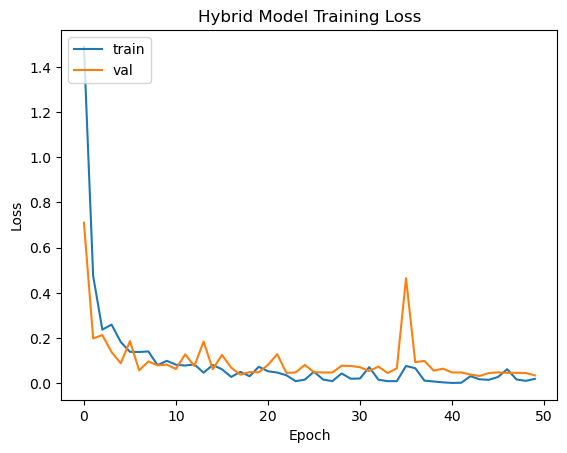

In [8]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Hybrid Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

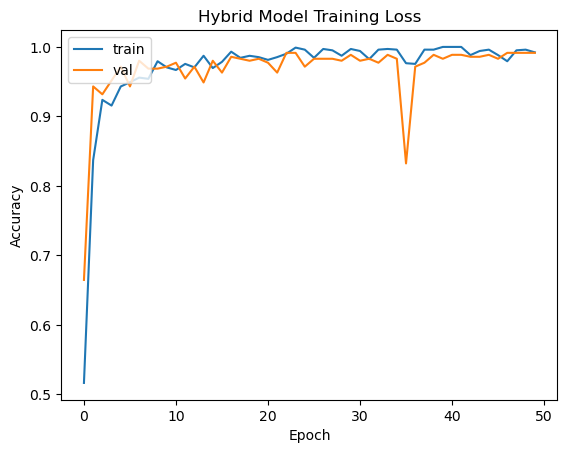

In [9]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Hybrid Model Training Loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

Text(0.5, 1.0, 'Confusion Matrix From Hybrid Model')

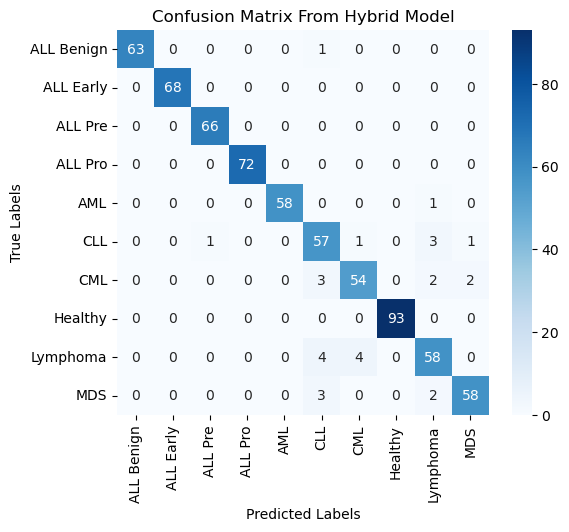

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
y_pred = model.predict(generator_test)
y_pred=np.argmax(y_pred,axis=1)
y_test = generator_test.classes

array = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(array, index = ['ALL Benign',
 'ALL Early',
 'ALL Pre',
 'ALL Pro',
 'AML',
 'CLL',
 'CML',
 'Healthy',
 'Lymphoma',
 'MDS'],
                  columns = ['ALL Benign',
 'ALL Early',
 'ALL Pre',
 'ALL Pro',
 'AML',
 'CLL',
 'CML',
 'Healthy',
 'Lymphoma',
 'MDS'])
plt.figure(figsize = (6,5))
cm_plot = sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
cm_plot.set_xlabel('Predicted Labels')
cm_plot.set_ylabel('True Labels')
cm_plot.set_title('Confusion Matrix From Hybrid Model', size=12)

<AxesSubplot:>

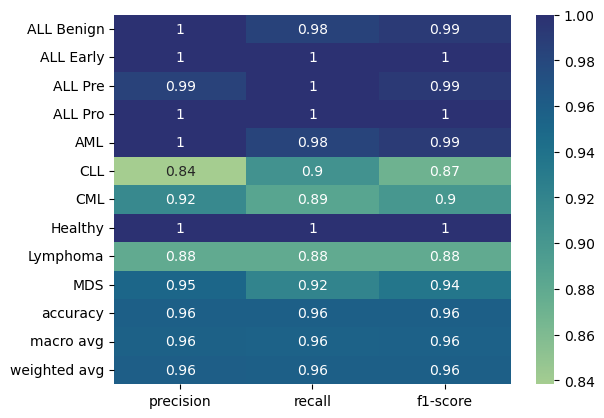

In [12]:
from sklearn.metrics import classification_report
import seaborn as sns
clf_report = classification_report(y_test, y_pred, target_names=['ALL Benign',
 'ALL Early',
 'ALL Pre',
 'ALL Pro',
 'AML',
 'CLL',
 'CML',
 'Healthy',
 'Lymphoma',
 'MDS'], output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True,  cmap="crest")

ROC AUC score: 0.9755529494344746


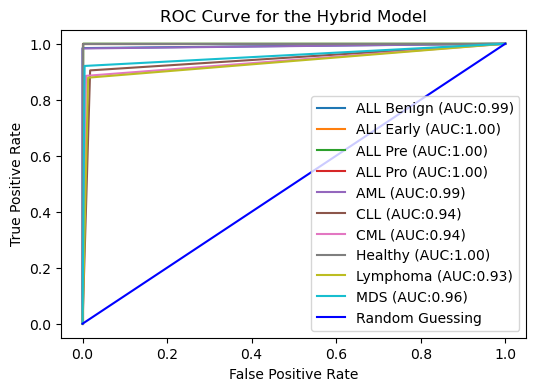

In [13]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

#y_pred = vit.predict(x_test)
#y_pred=np.argmax(y_pred,axis=1)

target= ['ALL Benign',
 'ALL Early',
 'ALL Pre',
 'ALL Pro',
 'AML',
 'CLL',
 'CML',
 'Healthy',
 'Lymphoma',
 'MDS']

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (6, 4))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(y_test, y_pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
c_ax.set_title('ROC Curve for the Hybrid Model', size=12)
plt.show()

In [14]:
def get_img_array(img):
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
grad_dir = "F:/WBC/WBC/grad"

datagen_grad = ImageDataGenerator(rescale=1./255)

generator_grad = datagen_grad.flow_from_directory(directory=grad_dir,
                                                  target_size=(384, 384),
                                                  batch_size=10,
                                                  shuffle=False)

Found 10 images belonging to 10 classes.


(10, 384, 384, 3)


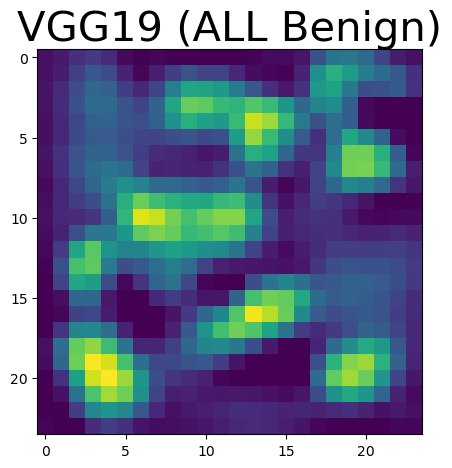

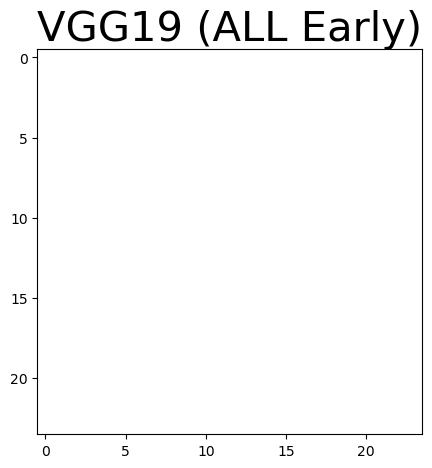

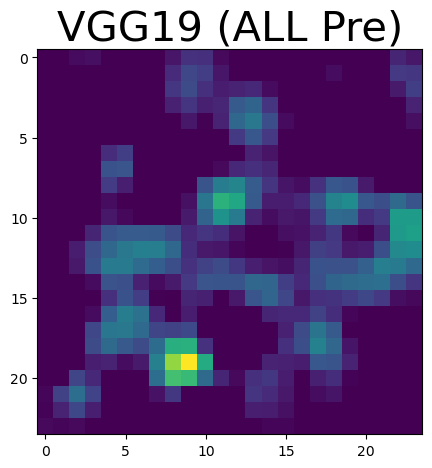

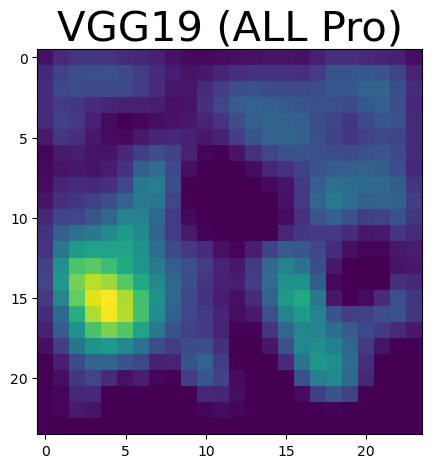

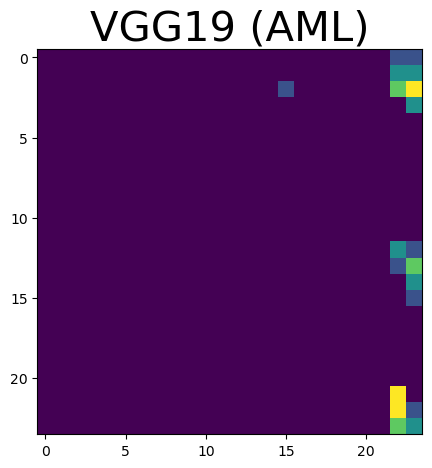

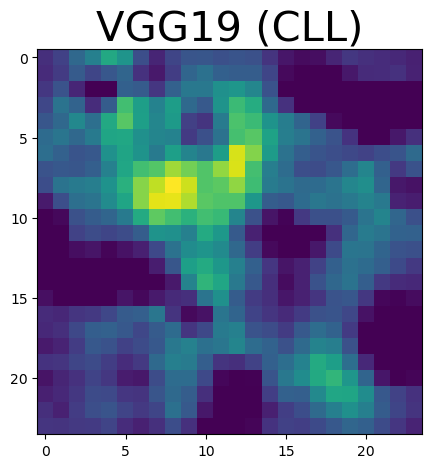

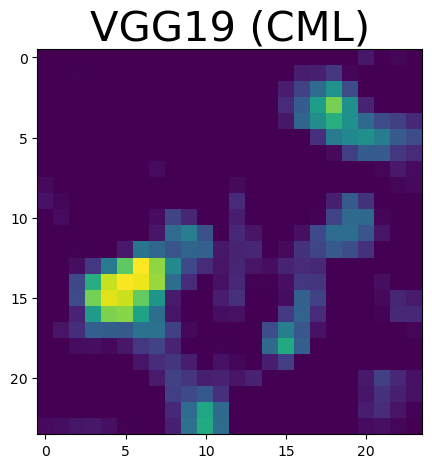

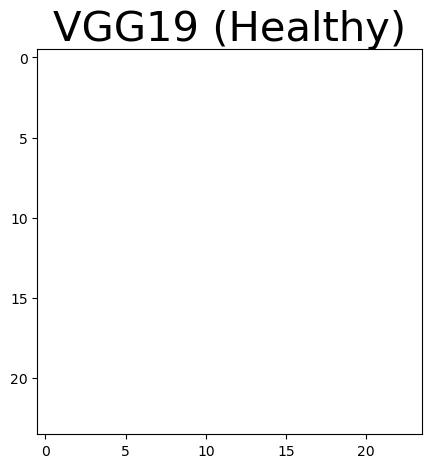

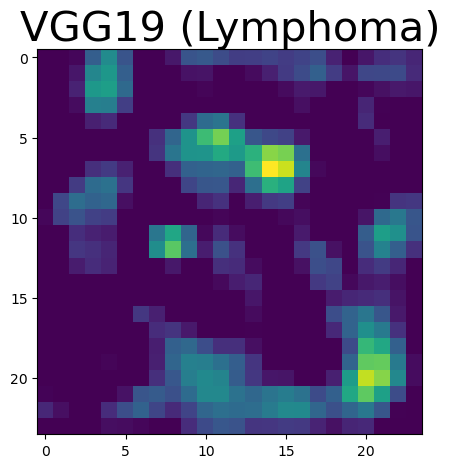

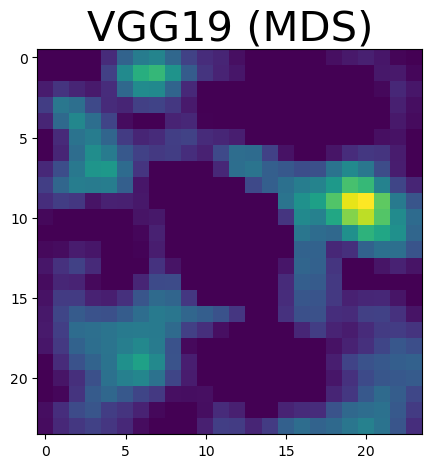

In [16]:
img_arrays = next(iter(generator_grad))[0]
print(img_arrays.shape)
i = 0
# plot utils
for img_array in img_arrays:
    # Generate class activation heatmap
    img_array = get_img_array(img_array)
    heatmap = make_gradcam_heatmap(img_array, model, "block5_conv4")
    plt.figure(figsize=(5, 5))
    
    plt.title('VGG19 ('+str(list(generator_grad.class_indices)[i])+')', fontdict = {'fontsize' : 30})
    plt.imshow(heatmap/255)
    i+=1

In [17]:
def save_and_display_gradcam(
    img,
    heatmap,
    target=None,
    pred=None,
    cam_path="cam.jpg",
    cmap="jet",  # inferno, viridis
    alpha=0.6,
    plot=None,
):
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap(cmap)

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[0], img.shape[1]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = img*255 + jet_heatmap * alpha
    superimposed_img = keras.utils.array_to_img(superimposed_img)
    return superimposed_img

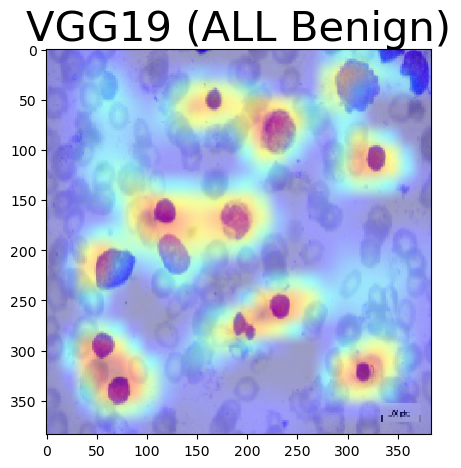

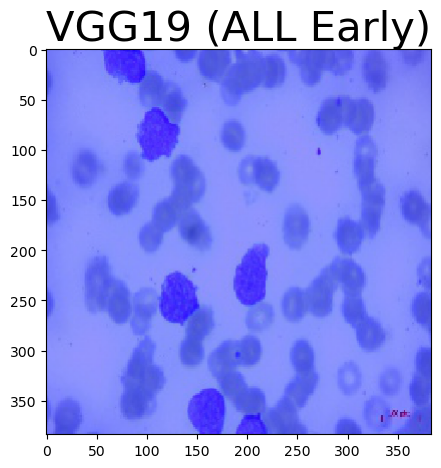

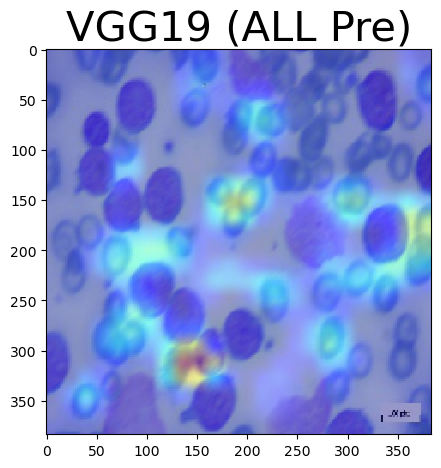

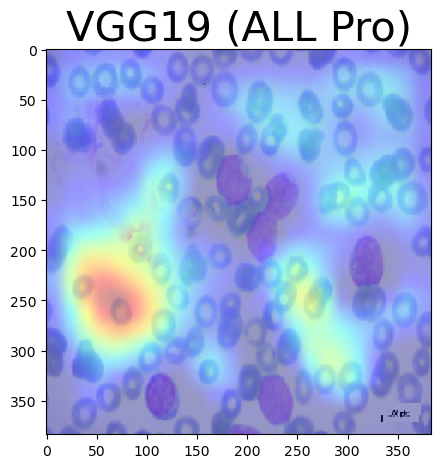

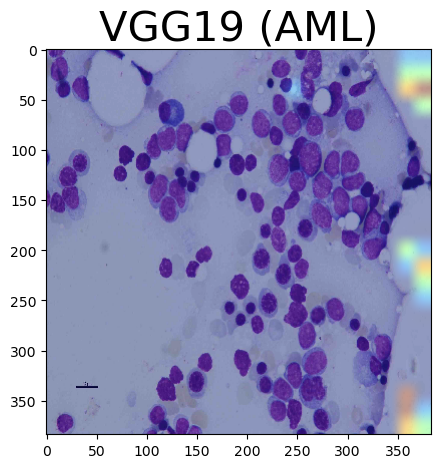

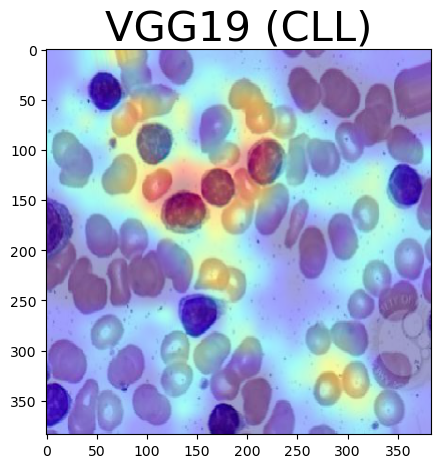

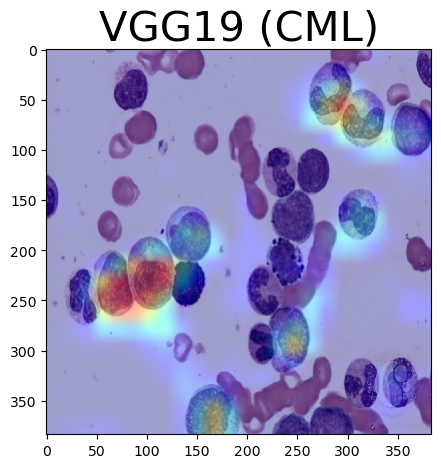

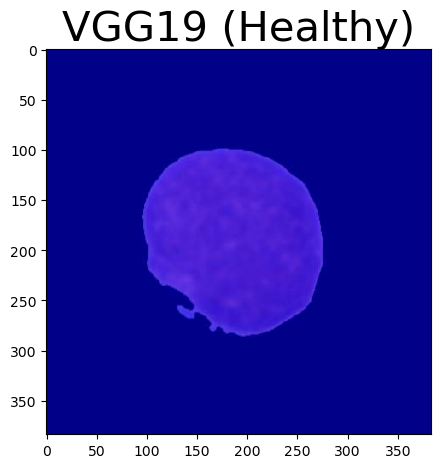

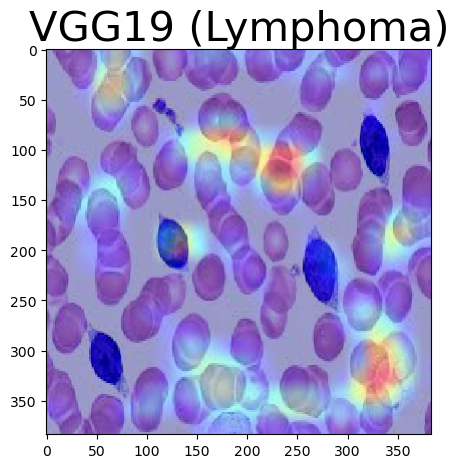

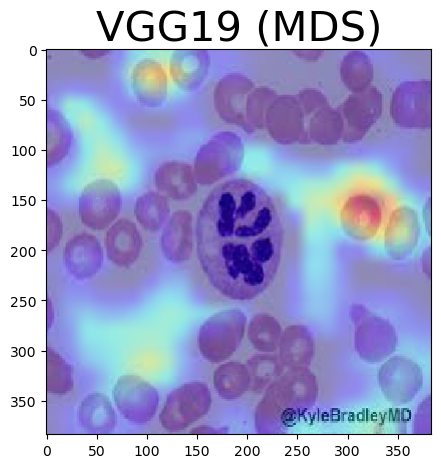

In [18]:
samples, labels = next(iter(generator_grad))
i = 0
for sample, label in zip(samples, labels):
    # preparing
    sample = sample
    img_array = sample[tf.newaxis, ...]

    # get heatmaps
    heatmap = make_gradcam_heatmap(img_array, model, "block5_conv4")

    # overaly heatmap and input sample
    overlay_a = save_and_display_gradcam(sample, heatmap)

    # ploting stuff
    plt.figure(figsize=(5, 5))
    
    plt.title('VGG19 ('+str(list(generator_grad.class_indices)[i])+')', fontdict = {'fontsize' : 30})
    plt.imshow(overlay_a)
    i+=1
    

In [19]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import random

(384, 384, 3)


100%|██████████| 1000/1000 [00:19<00:00, 51.48it/s]


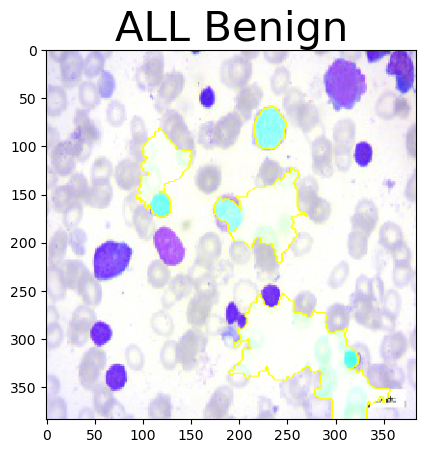

(384, 384, 3)


100%|██████████| 1000/1000 [00:13<00:00, 71.55it/s]


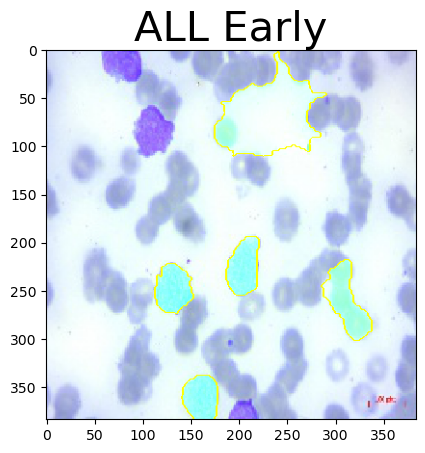

(384, 384, 3)


100%|██████████| 1000/1000 [00:15<00:00, 65.28it/s]


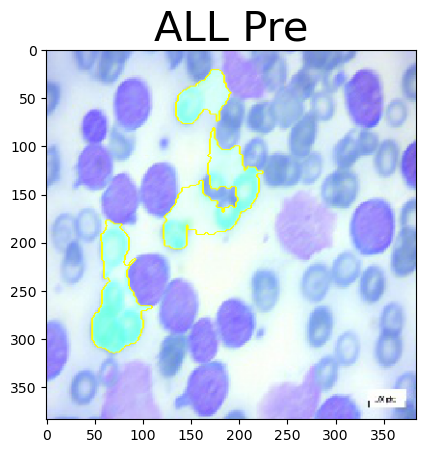

(384, 384, 3)


100%|██████████| 1000/1000 [00:14<00:00, 67.43it/s]


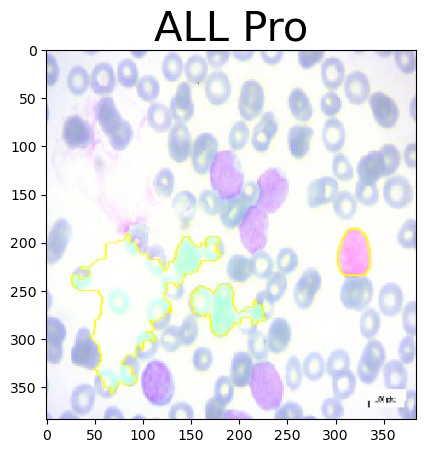

(384, 384, 3)


100%|██████████| 1000/1000 [00:15<00:00, 63.63it/s]


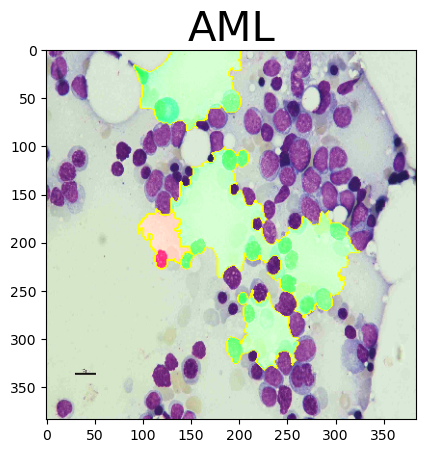

(384, 384, 3)


100%|██████████| 1000/1000 [00:14<00:00, 67.98it/s]


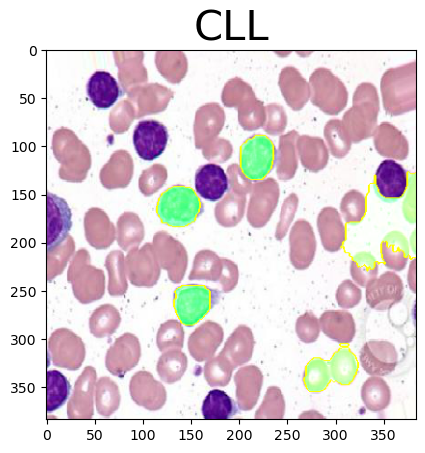

(384, 384, 3)


100%|██████████| 1000/1000 [00:14<00:00, 68.20it/s]


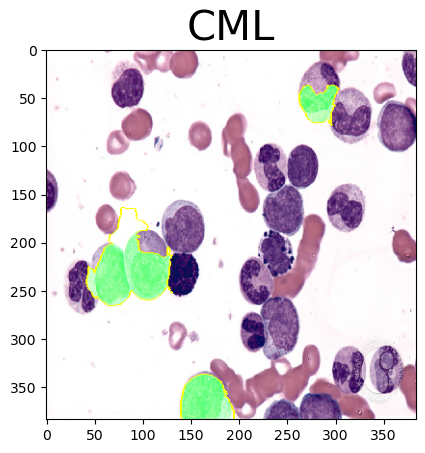

(384, 384, 3)


100%|██████████| 1000/1000 [00:20<00:00, 48.47it/s]


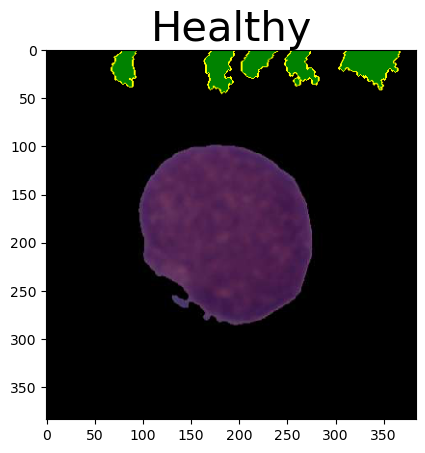

(384, 384, 3)


100%|██████████| 1000/1000 [00:15<00:00, 65.33it/s]


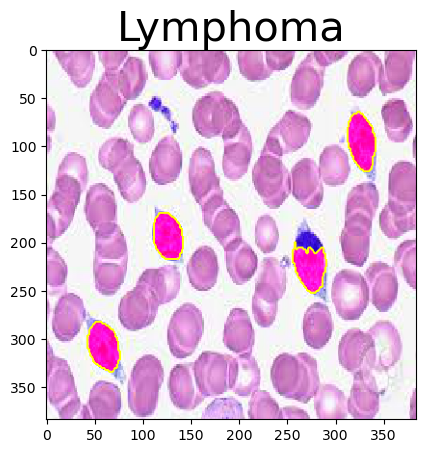

(384, 384, 3)


100%|██████████| 1000/1000 [00:14<00:00, 70.27it/s]


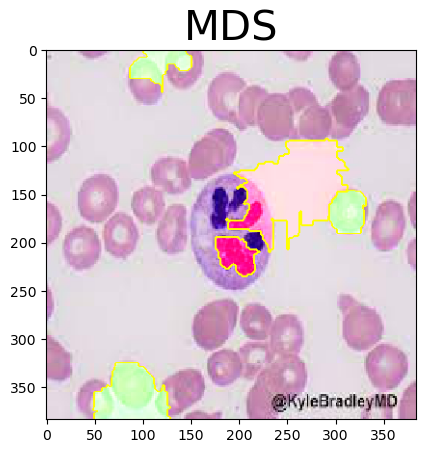

In [20]:
samples, labels = next(iter(generator_grad))
i = 0
for sample, label in zip(samples, labels):
    explainer = lime_image.LimeImageExplainer(random_state=42)
    print(sample.shape)
    explanation = explainer.explain_instance(
             sample, 
             model.predict
    )
    #plt.imshow(x_train[10])
    image, mask = explanation.get_image_and_mask(
             model.predict(
                  sample.reshape((1,384,384,3))
             ).argmax(axis=1)[0],
             positive_only=False, 
             hide_rest=False)
    plt.imshow(mark_boundaries(image, mask))
    plt.title(str(list(generator_grad.class_indices)[i]), fontdict = {'fontsize' : 30})
    i+=1
    plt.show()